In [1]:
from IPython.display import clear_output

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [3]:
%load_ext pycodestyle_magic

In [4]:
import re
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from string import ascii_lowercase
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.multinomial import Multinomial

%matplotlib inline

# Препроцессинг текстовых данных

In [5]:
!wget https://s3.amazonaws.com/text-datasets/nietzsche.txt

--2021-01-07 05:31:56--  https://s3.amazonaws.com/text-datasets/nietzsche.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600901 (587K) [text/plain]
Saving to: ‘nietzsche.txt’

nietzsche.txt       100%[===================>] 586.82K  1.84MB/s    in 0.3s    

2021-01-07 05:31:57 (1.84 MB/s) - ‘nietzsche.txt’ saved [600901/600901]



Мне кажется, если вручную разбить текст Ницше на предложения (и исходя из средней длины предложения уже выбирать MAX_LEN), то данные для нейронки будут чище.

In [6]:
with open('nietzsche.txt', encoding='utf-8') as f:
    # приводим к нижнему регистру
    text = f.read().lower()

    # заменяем на пробел всё, кроме латиницы в нижнем регистре и знаков,
    # которые могут завершать предложение – они нам ещё пригодятся (:
    text = re.sub(r'[^a-z\.\?\! ]', ' ', text)

    # стягиваем все получившиеся последовательности пробелов в один пробел
    text = re.sub(r'\s+', ' ', text)

In [7]:
text

'preface supposing that truth is a woman what then? is there not ground for suspecting that all philosophers in so far as they have been dogmatists have failed to understand women that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth have been unskilled and unseemly methods for winning a woman? certainly she has never allowed herself to be won and at present every kind of dogma stands with sad and discouraged mien if indeed it stands at all! for there are scoffers who maintain that it has fallen that all dogma lies on the ground nay more that it is at its last gasp. but to speak seriously there are good grounds for hoping that all dogmatizing in philosophy whatever solemn whatever conclusive and decided airs it has assumed may have been only a noble puerilism and tyronism and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and absolute philosophical

In [8]:
# разбиваем на предложения по последовательностям из завершающих символов
# не забываем, что после ., ? или ! обычно идёт пробел (:
# от re.split() часто остаются пустые строки,
# удаляем их сразу, иначе потом возникнут проблемки

sents = [sent for sent in re.split(r'[\.\?\!]+ ?', text) if sent]

In [9]:
sents[:10]

['preface supposing that truth is a woman what then',
 'is there not ground for suspecting that all philosophers in so far as they have been dogmatists have failed to understand women that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth have been unskilled and unseemly methods for winning a woman',
 'certainly she has never allowed herself to be won and at present every kind of dogma stands with sad and discouraged mien if indeed it stands at all',
 'for there are scoffers who maintain that it has fallen that all dogma lies on the ground nay more that it is at its last gasp',
 'but to speak seriously there are good grounds for hoping that all dogmatizing in philosophy whatever solemn whatever conclusive and decided airs it has assumed may have been only a noble puerilism and tyronism and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and absolute 

In [10]:
len(sents)

3222

Кажется, не только Лев Толстой любил длинные предложения. :( Из-за этого в моем датасете намного меньше образцов.

In [12]:
np.mean([len(sent) for sent in sents])

178.8234016139044

Зато они длиннее! Padding будем делать до 150. (:
<br>
Векторизуем Ницше.

In [13]:
# будем индексировать пробел как 0, а буквы – начиная с 1

ascii_lowercase = ' ' + ascii_lowercase
CHAR_TO_INDEX = {w: i for i, w in enumerate(ascii_lowercase)}

In [14]:
MAX_LEN = 150

# создаем тензоры X и y, в X – предложения,
# в y – следующий символ для каждого предложения

X = torch.zeros((len(sents), MAX_LEN), dtype=int)
y = torch.zeros((len(sents)), dtype=int)
for i in range(len(sents)):
    for j, w in enumerate(sents[i]):
        if j == MAX_LEN:
            y[i] = CHAR_TO_INDEX[w]
            break
        else:
            X[i][j] = CHAR_TO_INDEX[w]

In [15]:
X[1]

tensor([ 9, 19,  0, 20,  8,  5, 18,  5,  0, 14, 15, 20,  0,  7, 18, 15, 21, 14,
         4,  0,  6, 15, 18,  0, 19, 21, 19, 16,  5,  3, 20,  9, 14,  7,  0, 20,
         8,  1, 20,  0,  1, 12, 12,  0, 16,  8,  9, 12, 15, 19, 15, 16,  8,  5,
        18, 19,  0,  9, 14,  0, 19, 15,  0,  6,  1, 18,  0,  1, 19,  0, 20,  8,
         5, 25,  0,  8,  1, 22,  5,  0,  2,  5,  5, 14,  0,  4, 15,  7, 13,  1,
        20,  9, 19, 20, 19,  0,  8,  1, 22,  5,  0,  6,  1,  9, 12,  5,  4,  0,
        20, 15,  0, 21, 14,  4,  5, 18, 19, 20,  1, 14,  4,  0, 23, 15, 13,  5,
        14,  0, 20,  8,  1, 20,  0, 20,  8,  5,  0, 20,  5, 18, 18,  9,  2, 12,
         5,  0, 19,  5, 18,  9])

In [16]:
y[1]

tensor(15)

In [17]:
# создаём датасет и загружаем его в loader

batch_size = 64

nietzsche_dataset = TensorDataset(X, y)
nietzsche_loader = DataLoader(nietzsche_dataset, batch_size, shuffle=True)

# Генерация своих данных
## Задача
*   Сгенерировать последовательности цифр $0\dots9$, задающиеся следующим образом:
    *   $x_{0,\ 1\ \dots\ i-1,\ i}$ – последовательность цифр
    *   $y_0 = x_0, y_i = (x_0 + x_i) \bmod 10$
*   Научить модель предсказывать $y_i$ по $x_{0,\ 1\ \dots\ i}$
*   Опробовать RNN, LSTM, GRU


Сгенерируем 1000 последовательностей длиной 25.

In [18]:
X = np.random.randint(10, size=(1000, 25), dtype=int)
y = np.zeros((1000, 25), dtype=int)

In [19]:
X[:10]

array([[0, 8, 9, 5, 6, 7, 0, 4, 6, 5, 7, 1, 4, 5, 6, 8, 9, 2, 4, 1, 9, 1,
        5, 9, 8],
       [3, 4, 1, 5, 3, 6, 4, 2, 7, 9, 7, 4, 9, 8, 0, 4, 6, 8, 7, 3, 6, 7,
        0, 1, 4],
       [3, 1, 6, 6, 1, 3, 9, 2, 7, 6, 7, 1, 0, 0, 8, 4, 0, 0, 8, 9, 3, 3,
        0, 8, 9],
       [8, 9, 4, 0, 3, 6, 2, 9, 4, 8, 7, 2, 0, 5, 1, 3, 3, 7, 1, 1, 3, 2,
        7, 4, 9],
       [5, 5, 4, 9, 3, 8, 5, 7, 9, 1, 7, 1, 0, 4, 1, 1, 7, 4, 8, 3, 3, 3,
        0, 9, 3],
       [3, 6, 1, 5, 9, 7, 4, 3, 6, 0, 9, 8, 7, 1, 3, 4, 1, 5, 9, 4, 0, 3,
        8, 2, 2],
       [5, 0, 6, 5, 3, 6, 3, 7, 1, 6, 3, 7, 6, 6, 6, 1, 9, 4, 2, 9, 8, 0,
        2, 2, 8],
       [9, 8, 8, 8, 2, 9, 5, 4, 6, 1, 2, 4, 6, 2, 5, 4, 7, 4, 8, 2, 4, 3,
        8, 7, 4],
       [6, 4, 3, 1, 1, 4, 9, 1, 4, 8, 1, 1, 4, 4, 3, 0, 3, 1, 8, 4, 0, 7,
        0, 5, 3],
       [6, 0, 0, 2, 8, 5, 1, 7, 9, 9, 5, 2, 2, 2, 9, 9, 4, 2, 3, 6, 5, 6,
        9, 2, 5]])

In [20]:
for i in range(1000):
    y[i][0] = X[i][0]
    for j in range(1, 25):
        y[i][j] = (X[i][j] + X[i][0]) % 10

In [21]:
y[:10]

array([[0, 8, 9, 5, 6, 7, 0, 4, 6, 5, 7, 1, 4, 5, 6, 8, 9, 2, 4, 1, 9, 1,
        5, 9, 8],
       [3, 7, 4, 8, 6, 9, 7, 5, 0, 2, 0, 7, 2, 1, 3, 7, 9, 1, 0, 6, 9, 0,
        3, 4, 7],
       [3, 4, 9, 9, 4, 6, 2, 5, 0, 9, 0, 4, 3, 3, 1, 7, 3, 3, 1, 2, 6, 6,
        3, 1, 2],
       [8, 7, 2, 8, 1, 4, 0, 7, 2, 6, 5, 0, 8, 3, 9, 1, 1, 5, 9, 9, 1, 0,
        5, 2, 7],
       [5, 0, 9, 4, 8, 3, 0, 2, 4, 6, 2, 6, 5, 9, 6, 6, 2, 9, 3, 8, 8, 8,
        5, 4, 8],
       [3, 9, 4, 8, 2, 0, 7, 6, 9, 3, 2, 1, 0, 4, 6, 7, 4, 8, 2, 7, 3, 6,
        1, 5, 5],
       [5, 5, 1, 0, 8, 1, 8, 2, 6, 1, 8, 2, 1, 1, 1, 6, 4, 9, 7, 4, 3, 5,
        7, 7, 3],
       [9, 7, 7, 7, 1, 8, 4, 3, 5, 0, 1, 3, 5, 1, 4, 3, 6, 3, 7, 1, 3, 2,
        7, 6, 3],
       [6, 0, 9, 7, 7, 0, 5, 7, 0, 4, 7, 7, 0, 0, 9, 6, 9, 7, 4, 0, 6, 3,
        6, 1, 9],
       [6, 6, 6, 8, 4, 1, 7, 3, 5, 5, 1, 8, 8, 8, 5, 5, 0, 8, 9, 2, 1, 2,
        5, 8, 1]])

Всё правильно! Теперь оставим только последний столбец.

In [22]:
y = y[:,-1]

In [23]:
y

array([8, 7, 2, 7, 8, 5, 3, 3, 9, 1, 2, 0, 0, 6, 2, 0, 2, 9, 9, 1, 0, 8,
       6, 9, 6, 1, 2, 1, 4, 5, 8, 5, 6, 6, 7, 2, 2, 5, 8, 8, 6, 1, 7, 8,
       1, 8, 3, 2, 9, 3, 3, 3, 6, 5, 0, 7, 7, 4, 9, 7, 2, 9, 2, 7, 3, 1,
       0, 9, 2, 6, 8, 4, 0, 2, 8, 2, 8, 0, 3, 3, 6, 2, 3, 8, 1, 1, 4, 3,
       0, 4, 8, 6, 0, 5, 5, 1, 9, 7, 6, 4, 1, 6, 9, 5, 9, 9, 4, 0, 3, 9,
       3, 9, 1, 4, 1, 6, 8, 9, 7, 9, 0, 3, 3, 2, 1, 3, 9, 2, 7, 3, 6, 1,
       2, 4, 9, 1, 1, 3, 0, 5, 3, 0, 5, 6, 0, 6, 6, 2, 0, 0, 0, 8, 7, 3,
       7, 8, 5, 6, 3, 5, 1, 5, 4, 9, 6, 4, 7, 9, 3, 7, 5, 3, 5, 5, 6, 5,
       1, 6, 7, 0, 5, 3, 1, 0, 6, 4, 9, 6, 7, 8, 1, 9, 7, 1, 7, 8, 6, 6,
       0, 6, 5, 9, 6, 5, 9, 6, 4, 5, 5, 3, 9, 4, 9, 9, 5, 0, 5, 1, 3, 2,
       5, 6, 1, 1, 9, 6, 5, 1, 4, 4, 7, 9, 1, 2, 9, 8, 9, 8, 5, 7, 9, 9,
       4, 1, 1, 0, 4, 2, 4, 3, 1, 0, 1, 6, 2, 2, 4, 3, 5, 5, 6, 7, 9, 7,
       5, 3, 0, 5, 6, 3, 2, 9, 8, 3, 6, 4, 0, 9, 5, 3, 9, 1, 4, 1, 8, 9,
       9, 8, 6, 4, 7, 2, 6, 4, 8, 2, 3, 4, 7, 4, 3,

In [24]:
X, y = torch.from_numpy(X), torch.from_numpy(y)

In [25]:
# создаём датасет и загружаем его в loader

batch_size = 64

numbers_dataset = TensorDataset(X, y)
numbers_loader = torch.utils.data.DataLoader(numbers_dataset, batch_size,
                                             shuffle=True)

# Архитектура нейронной сети
Создадим один класс NeuralNetwork для всех типов рекуррентных ячеек.

In [26]:
# здесь rnn – тип рекуррентной ячейки (RNN, LSTM или GRU)


class RecurrentNetwork(torch.nn.Module):
    def __init__(self, rnn, vocab_size, embedding_dim, hidden_dim, n_classes):
        super(RecurrentNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = rnn(embedding_dim, hidden_dim, batch_first=True)
        self.dense = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, X):
        out = self.embedding(X)
        _, state = self.rnn(out)
        pred = self.dense(state[0])
        if isinstance(self.rnn, torch.nn.LSTM):
            pred = pred.squeeze(0)
        return pred

Функция для генерации предложений на текстовых данных – она нам ещё пригодится в следующем задании.

In [27]:
def generate_sent(model, sents):

    # функция берёт случайное предложение,
    # генерирует следующее обученной моделью
    # и возвращает удобочитаемую f-строку с обоими предложениями

    model.eval()

    MAX_LEN = 150

    text = np.random.choice(sents)

    for i in range(MAX_LEN):
        x_pred = torch.tensor([[CHAR_TO_INDEX[char]
                                for char in text[-MAX_LEN:]]],
                              dtype=torch.long)
        preds = model(x_pred)[0]
        probas = Multinomial(1, torch.softmax(preds, 0)).sample()
        next_char_id = probas.argmax()
        next_char = ascii_lowercase[next_char_id]
        text += next_char

    # оба предложения капитализированы и заканчиваются на "!"
    # я могла бы ещё подумать над генерацией знака препинания,
    # но это сложно и долго, а так смешнее (:

    original_sent = text[:MAX_LEN].capitalize().strip()
    generated_sent = text[MAX_LEN:].capitalize().strip()

    # так как 150 символов не помещаются целиком в одну строку вывода колаба,
    # предложения пришлось разбить на две строки
    # чтобы не резать слова, я разбила предложения на две строки
    # по индексу первого пробела во второй половине предложения

    break_index_1 = original_sent.find(' ', 74)
    break_index_2 = generated_sent.find(' ', 74)

    result = f'''
Начало оригинального Ницще:
"{original_sent[:break_index_1]}
{original_sent[break_index_1 + 1:]}!"

Продолжение НейроНицше:
"{generated_sent[:break_index_2]}
{generated_sent[break_index_2 + 1:]}!"
'''

    return result

Напишем функцию train_model, чтобы не копировать 4 раза один и тот же кусок кода. Функция возвращает обученную модель и массив лоссов (пригодится, чтобы графики строить).

In [28]:
def train_model(model, loader, criterion, optimizer, n_epochs=100,
                generate_sents=False):
    train_losses = []

    for epoch in tqdm(range(1, n_epochs + 1)):
        start = time.time()
        train_loss = 0.0
        model.train()

        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred = model.forward(X_batch)
            loss = criterion(y_pred, y_batch)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss /= len(loader)
        train_losses.append(train_loss)
        sec = time.time() - start
        stat = f'Epoch: {epoch}, time: {sec:.1f}s, loss: {train_loss:.3f}'
        print(stat)

        if generate_sents:
            print(generate_sent(model, sents))

    return model, train_losses

# Рекуррентные сети на последовательностях цифр
## RNN

In [29]:
vocab_size = 10
embedding_dim = 64
hidden_dim = 128

In [30]:
model = RecurrentNetwork(
    torch.nn.RNN, vocab_size, embedding_dim, hidden_dim, 10
    )

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [32]:
model, train_losses = train_model(model, numbers_loader, criterion, optimizer)

Epoch: 1, time: 0.5s, loss: 2.326
Epoch: 2, time: 0.3s, loss: 2.295
Epoch: 3, time: 0.2s, loss: 2.277
Epoch: 4, time: 0.2s, loss: 2.260
Epoch: 5, time: 0.2s, loss: 2.247
Epoch: 6, time: 0.2s, loss: 2.239
Epoch: 7, time: 0.2s, loss: 2.229
Epoch: 8, time: 0.2s, loss: 2.222
Epoch: 9, time: 0.2s, loss: 2.216
Epoch: 10, time: 0.2s, loss: 2.206
Epoch: 11, time: 0.2s, loss: 2.202
Epoch: 12, time: 0.2s, loss: 2.195
Epoch: 13, time: 0.2s, loss: 2.189
Epoch: 14, time: 0.2s, loss: 2.184
Epoch: 15, time: 0.2s, loss: 2.177
Epoch: 16, time: 0.2s, loss: 2.170
Epoch: 17, time: 0.2s, loss: 2.168
Epoch: 18, time: 0.2s, loss: 2.162
Epoch: 19, time: 0.2s, loss: 2.159
Epoch: 20, time: 0.2s, loss: 2.148
Epoch: 21, time: 0.2s, loss: 2.145
Epoch: 22, time: 0.2s, loss: 2.138
Epoch: 23, time: 0.2s, loss: 2.134
Epoch: 24, time: 0.2s, loss: 2.131
Epoch: 25, time: 0.2s, loss: 2.121
Epoch: 26, time: 0.2s, loss: 2.113
Epoch: 27, time: 0.2s, loss: 2.111
Epoch: 28, time: 0.2s, loss: 2.105
Epoch: 29, time: 0.2s, loss: 

Построим график лоссов.

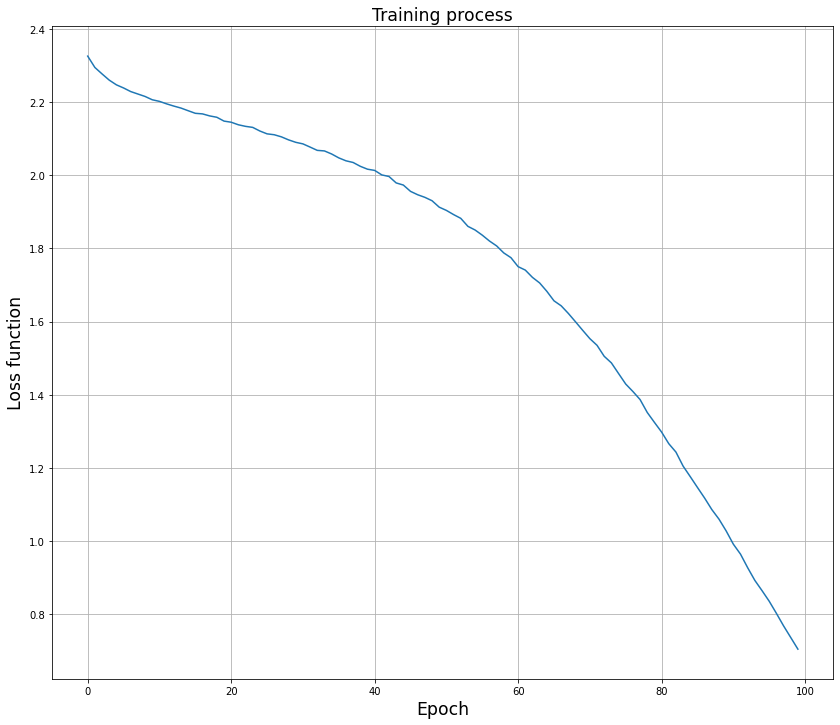

In [33]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

График не очень хороший. Лосс падает, но как-то неэффективно (и после 100 эпох лосс 0.705, что всё ещё очень высоко).<br>
Попробуем LSTM.
## LSTM

In [34]:
model = RecurrentNetwork(
    torch.nn.LSTM, vocab_size, embedding_dim, hidden_dim, 10
    )

In [35]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [36]:
model, train_losses = train_model(model, numbers_loader, criterion, optimizer)

Epoch: 1, time: 0.5s, loss: 2.308
Epoch: 2, time: 0.5s, loss: 2.304
Epoch: 3, time: 0.5s, loss: 2.301
Epoch: 4, time: 0.5s, loss: 2.299
Epoch: 5, time: 0.5s, loss: 2.297
Epoch: 6, time: 0.5s, loss: 2.295
Epoch: 7, time: 0.5s, loss: 2.293
Epoch: 8, time: 0.5s, loss: 2.291
Epoch: 9, time: 0.5s, loss: 2.290
Epoch: 10, time: 0.5s, loss: 2.288
Epoch: 11, time: 0.5s, loss: 2.287
Epoch: 12, time: 0.5s, loss: 2.286
Epoch: 13, time: 0.5s, loss: 2.284
Epoch: 14, time: 0.5s, loss: 2.283
Epoch: 15, time: 0.5s, loss: 2.282
Epoch: 16, time: 0.5s, loss: 2.280
Epoch: 17, time: 0.5s, loss: 2.279
Epoch: 18, time: 0.5s, loss: 2.278
Epoch: 19, time: 0.5s, loss: 2.276
Epoch: 20, time: 0.5s, loss: 2.276
Epoch: 21, time: 0.5s, loss: 2.276
Epoch: 22, time: 0.5s, loss: 2.274
Epoch: 23, time: 0.5s, loss: 2.274
Epoch: 24, time: 0.5s, loss: 2.272
Epoch: 25, time: 0.5s, loss: 2.271
Epoch: 26, time: 0.6s, loss: 2.270
Epoch: 27, time: 0.5s, loss: 2.269
Epoch: 28, time: 0.5s, loss: 2.267
Epoch: 29, time: 0.5s, loss: 

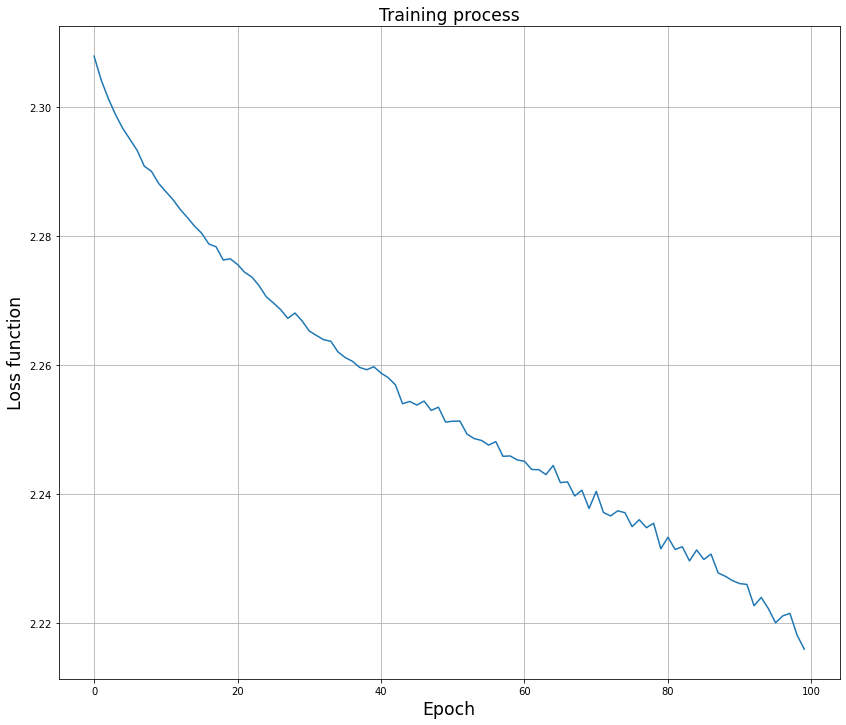

In [37]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

LSTM работает ещё хуже – за 100 эпох значения loss function никогда не опускались ниже 2.<br>
Попробуем GRU.
## GRU

In [38]:
model = RecurrentNetwork(
    torch.nn.GRU, vocab_size, embedding_dim, hidden_dim, 10
    )

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [40]:
model, train_losses = train_model(model, numbers_loader, criterion, optimizer)

Epoch: 1, time: 0.4s, loss: 2.315
Epoch: 2, time: 0.5s, loss: 2.301
Epoch: 3, time: 0.4s, loss: 2.292
Epoch: 4, time: 0.5s, loss: 2.286
Epoch: 5, time: 0.4s, loss: 2.281
Epoch: 6, time: 0.5s, loss: 2.278
Epoch: 7, time: 0.5s, loss: 2.274
Epoch: 8, time: 0.5s, loss: 2.270
Epoch: 9, time: 0.5s, loss: 2.268
Epoch: 10, time: 0.4s, loss: 2.266
Epoch: 11, time: 0.4s, loss: 2.264
Epoch: 12, time: 0.4s, loss: 2.263
Epoch: 13, time: 0.4s, loss: 2.261
Epoch: 14, time: 0.5s, loss: 2.260
Epoch: 15, time: 0.5s, loss: 2.256
Epoch: 16, time: 0.4s, loss: 2.256
Epoch: 17, time: 0.4s, loss: 2.256
Epoch: 18, time: 0.4s, loss: 2.255
Epoch: 19, time: 0.4s, loss: 2.256
Epoch: 20, time: 0.4s, loss: 2.253
Epoch: 21, time: 0.5s, loss: 2.252
Epoch: 22, time: 0.5s, loss: 2.250
Epoch: 23, time: 0.5s, loss: 2.250
Epoch: 24, time: 0.4s, loss: 2.249
Epoch: 25, time: 0.4s, loss: 2.249
Epoch: 26, time: 0.4s, loss: 2.249
Epoch: 27, time: 0.5s, loss: 2.246
Epoch: 28, time: 0.4s, loss: 2.248
Epoch: 29, time: 0.4s, loss: 

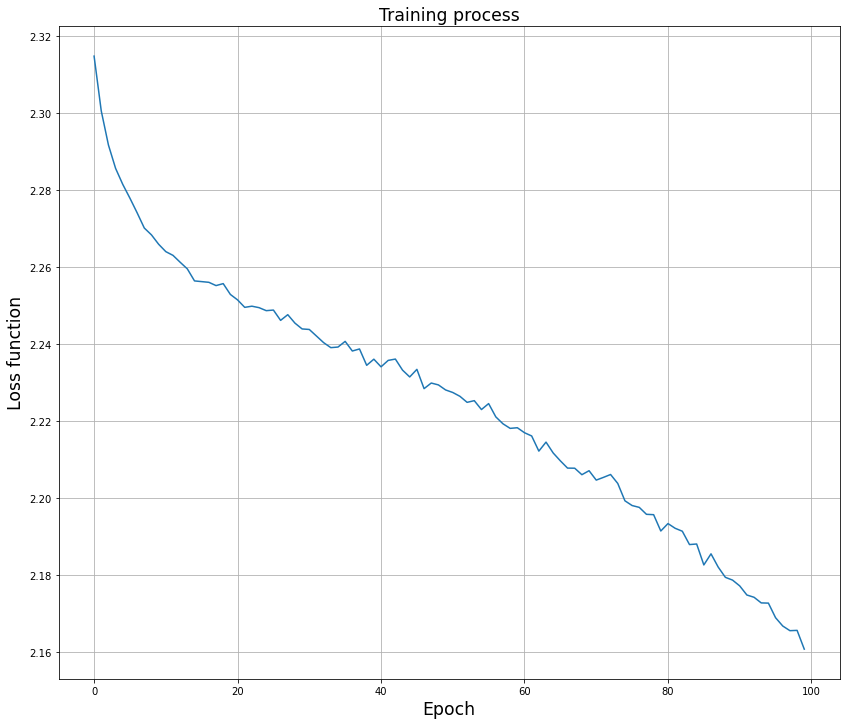

In [41]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

То же самое.<br>
На этих данных в качестве рекуррентного слоя нейронной сети лучше всего работает RNN.
# LSTM в задаче генерации текста Ницше
Обучим ту же архитектуру нейросети, но с LSTM в качестве рекуррентного слоя, на массиве текстов Ницше, и посмотрим, насколько хорошо у неё после каждой эпохи получается генерировать похожие предложения.<br>
В приведённых образцах первое предложение – Ницше, второе – сгенерированное нейросетью продолжение первого.

In [42]:
vocab_size = 27
embedding_dim = 64
hidden_dim = 128

In [43]:
model = RecurrentNetwork(
    torch.nn.LSTM, vocab_size, embedding_dim, hidden_dim, 10
    )

In [44]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [45]:
model, train_losses = train_model(
    model, nietzsche_loader, criterion, optimizer, generate_sents=True
    )

Epoch: 1, time: 9.2s, loss: 1.755

Начало оригинального Ницще:
"Let it at once be noted that in this first kind of morality the antithesis
good and bad means practically the same as noble and despicable the antithe!"

Продолжение НейроНицше:
"Sis good and evil is of a different originkpp q                           
                                       q                               qa    iwwszxohhzxsydhubyvphqsvuotzjmdck!"

Epoch: 2, time: 9.1s, loss: 1.486

Начало оригинального Ницще:
"A great man cdr agn   d      x                       e                    
                              cy h  q   k!"

Продолжение НейроНицше:
"
!"

Epoch: 3, time: 9.1s, loss: 1.440

Начало оригинального Ницще:
"On the other hand if one has once drifted hither with one s bark wellniaz qxcetqmrbaee
 avzplwdwfcjrcmv e        o                        a f!"

Продолжение НейроНицше:
"
z!"

Epoch: 4, time: 9.1s, loss: 1.398

Начало оригинального Ницще:
"Not what the saint is but what he was in the eyes 

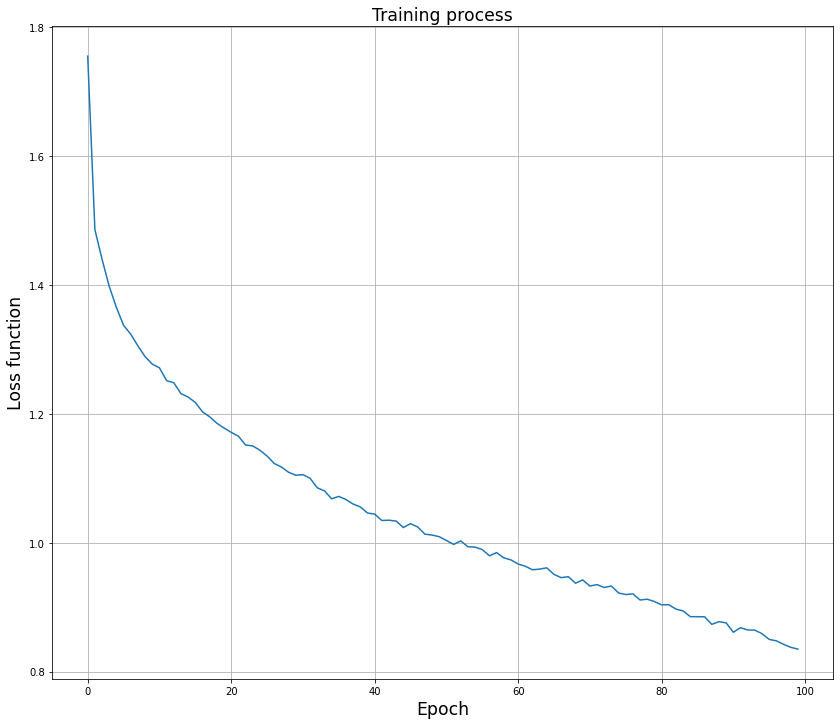

In [46]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

Функция лосса хорошая. Осмысленность сгенерированных фраз и связь между окончанием оригинальной фразы и началом сгенерированной быстро и ощутимо растёт вместе с эпохой. LSTM для задачи генерации текста отлично работает. (:<br>
<br>
**Проблема:** даже на последних эпохах нейросеть часто генерирует пустые фразы или фразы, в которых ни один токен не имеет никакого смысла в английском языке. Самая вероятная причина – плохо очищенные исходные данные (это видно даже по некоторым репликам оригинального Ницше, например, на эпохах 2, 3 и 4).<br>
<br>
А ещё реплики Нейроницше мне так понравились, что я их даже себе сохранила. Вместе с моделькой. (: